# Dataset Loading

In [1]:
# System Imports
import os, sys, shutil
from os.path import join, realpath
import json
import xml.etree.ElementTree as ET
from xml import etree
from random import choice
import random
from copy import deepcopy
import cv2
from random import choice
#import google.generativeai as genai
from pathlib import Path
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np
from scipy.ndimage import zoom
import colorsys
import random
import ast
import tempfile
from PIL import Image
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import re
from typing import Union, Dict


def show_image(example):
    try:
        image = read_image(example)
    except:
        image = cv2.imread(example)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Display the image using Matplotlib
    plt.figure(figsize=(10, 10))
    plt.imshow(image_rgb)
    plt.axis("off")  # Hide the axis
    plt.show()
    

def load_classes() -> dict:
    """Returns the List of Classes as Encoding Map"""

    with open("/kaggle/input/cghd1152/classes.json") as classes_file:
        return json.loads(classes_file.read())


def load_classes_ports() -> dict:
    """Reads Symbol Library from File"""

    with open("/kaggle/input/cghd1152/classes_ports.json") as json_file:
        return json.loads(json_file.read())


def load_properties() -> dict:
    """Loads the Properties RegEx File"""

    with open("/kaggle/input/cghd1152/properties.json") as json_file:
        return json.loads(json_file.read())


def _sample_info_from_path(path: str) -> tuple:
    """Extracts Sample Metadata from File Path"""

    drafter, _, file_name = os.path.normpath(path).split(os.sep)[-3:]
    circuit, drawing, picture = file_name.split("_")
    picture, suffix = picture.split(".")
    return drafter.split("_")[1], int(circuit[1:]), int(drawing[1:]), int(picture[1:]), suffix


def sample_name(sample: dict) -> str:
    """Returns the Name of a Sample"""

    return f"C{sample['circuit']}_D{sample['drawing']}_P{sample['picture']}"


def file_name(sample: dict) -> str:
    """return the Raw Image File Name of a Sample"""

    return f"{sample_name(sample)}.{sample['format']}"


def read_pascal_voc(path: str) -> dict:
    """Reads the Content of a Pascal VOC Annotation File"""

    root = ET.parse(path).getroot()
    circuit, drawing, picture = root.find("filename").text.split("_")
    drafter = int(os.path.normpath(path).split(os.sep)[-3].split("_")[1])

    return {"drafter": drafter,
            "circuit": int(circuit[1:]),
            "drawing": int(drawing[1:]),
            "picture": int(picture.split(".")[0][1:]),
            "format": picture.split(".")[-1],
            "width": int(root.find("size/width").text),
            "height": int(int(root.find("size/height").text)),
            "bboxes": [{"class": annotation.find("name").text,
                        "xmin": int(annotation.find("bndbox/xmin").text),
                        "xmax": int(annotation.find("bndbox/xmax").text),
                        "ymin": int(annotation.find("bndbox/ymin").text),
                        "ymax": int(annotation.find("bndbox/ymax").text),
                        "rotation": int(annotation.find("bndbox/rotation").text) if annotation.find("bndbox/rotation") is not None else None,
                        "text": annotation.find("text").text if annotation.find("text") is not None else None}
                       for annotation in root.findall('object')],
            "polygons": [], "points": []}


def read_labelme(path: str) -> dict:
    """Reads and Returns Geometric Objects from a LabelME JSON File"""

    with open(path) as json_file:
        json_data = json.load(json_file)

    drafter, circuit, drawing, picture, _ = _sample_info_from_path(path)
    suffix = json_data['imagePath'].split(".")[-1]

    return {'img_path': json_data['imagePath'].replace("\\", "/"), 'drafter': drafter, 'circuit': circuit,
            'drawing': drawing, 'picture': picture, 'format': suffix,
            'height': json_data['imageHeight'], 'width': json_data['imageWidth'], 'bboxes': [],
            'polygons': [{'class': shape['label'],
                          'bbox': {'xmin': min(point[0] for point in shape['points']),
                                   'ymin': min(point[1] for point in shape['points']),
                                   'xmax': max(point[0] for point in shape['points']),
                                   'ymax': max(point[1] for point in shape['points'])},
                          'points': shape['points'],
                          'rotation': shape.get('rotation', None),
                          'text': shape.get('text', None),
                          'group': shape.get('group_id', None)}
                         for shape in json_data['shapes']
                         if shape['shape_type'] == "polygon"],
            'points': [{'class': shape['label'], 'points': shape['points'][0],
                        'group': shape['group_id'] if 'group_id' in shape else None}
                       for shape in json_data['shapes']
                       if shape['shape_type'] == "point"]}


def read_dataset(drafter: int = None, circuit: int = None, segmentation=False, folder: str = None) -> list:
    """Reads all BB Annotation Files from Folder Structure
    This Method can be invoked from Anywhere, can be restricted to a specified drafter
    and can be use for both BB and Polygon Annotations. Alternative annotation sub-folder
    can be specified to read processed ground truth."""

    db_root = os.sep.join(realpath('/kaggle/input/cghd1152').split(os.sep))

    return sorted([(read_labelme if segmentation else read_pascal_voc)(join(root, file_name))
                   for root, _, files in os.walk(db_root)
                   for file_name in files
                   if (folder if folder else ("instances" if segmentation else "annotations")) in root and
                      (not circuit or f"C{circuit}_" in file_name) and
                      (drafter is None or f"drafter_{drafter}{os.sep}" in root)],
                  key=lambda sample: sample["circuit"]*100+sample["drawing"]*10+sample["picture"])


def read_image(sample: dict) -> np.ndarray:
    """Loads the Image Associated with a DB Sample"""

    db_root = os.sep.join(realpath('/kaggle/input/cghd1152').split(os.sep))

    return cv2.imread(join(db_root, f"drafter_{sample['drafter']}", "images", file_name(sample)))


def read_images(**kwargs) -> list:
    """Loads Images and BB Annotations and returns them as as List of Pairs"""

    return [(read_image(sample), sample) for sample in read_dataset(**kwargs)]



def get_path(d: dict, ds_loc='/kaggle/input/cghd1152', mask=False):
    if d["bboxes"]:
        name = file_name(d)
        old_path = os.path.join(ds_loc, f"drafter_{d['drafter']}", 'images', name)
    elif d['polygons']:
        name = d['img_path'].split("/")[-1]
        if mask:
            old_path = os.path.join(ds_loc, f"drafter_{d['drafter']}", 'segmentation', name)
        else:
            old_path = os.path.join(ds_loc, f"drafter_{d['drafter']}", 'images', name)
    elif d['background']:
        old_path = d['img_path']
    else:
        raise ValueError("Invalid sample dictionary format")
    return old_path


def sample_type(d: dict):
    if len(d.get("bboxes")) > 0:
        return 'voc'
    elif len(d.get("polygons")) > 0:
        return 'labelme'
    elif d.get('background') == True:
        return 'background'
    else:
        raise ValueError("Invalid sample dictionary format")


def get_bboxes(d: dict, non_component_classes=[], components_only=False):
    if d.get('bboxes'):
        t = 'bboxes'
        voc = True
    elif d.get('polygons'):
        t = 'polygons'
        voc = False
    elif d.get('background'):
        return []
    else:
        raise ValueError("Invalid sample dictionary format")

    bboxes = d[t]

    if not bboxes:
        raise ValueError("Empty bounding boxes list in sample")

    if voc:
        if not components_only:
            return [bbox for bbox in bboxes]
        else:
            return [bbox for bbox in bboxes if bbox['class'] not in non_component_classes]
    else:
        l = []
        for bbox in bboxes:
            b = bbox['bbox']
            b['class'] = bbox['class']
            if not components_only or (components_only and b['class'] not in non_component_classes):
                l.append(b)
        return l


def filter_dataset(combined_ds, class2category, non_component_classes, reducing: set, unknown: set, deleting: set):
    filtered_ds = deepcopy(combined_ds)
    for i, sample in enumerate(filtered_ds):
        if sample.get('bboxes') is not None:
            t = 'bboxes'
        elif sample.get('polygons') is not None:
            t = 'polygons'
        else:
            continue  # Skip samples without bounding boxes

        bboxes = sample[t]
        bboxes = [bbox for bbox in bboxes if bbox['class'] not in deleting]
        filtered_ds[i][t] = bboxes

        for j, bbox in enumerate(bboxes):
            if bbox['class'] in unknown:
                bbox['class'] = 'unknown'
            elif bbox['class'] in reducing:
                bbox['class'] = bbox['class'].split('.')[0]

    classes = set(class2category.keys()) - deleting - unknown - reducing
    class2category = {key: i for i, key in enumerate(classes)}
    instances_count, class_sorted_ds = count_instances(filtered_ds, class2category)
    return filtered_ds, classes, class2category, instances_count, class_sorted_ds


def establish_dirs(path='/kaggle/working/yolo_dataset/'):
    os.makedirs(os.path.join(path, 'val', 'images'), exist_ok=True)
    os.makedirs(os.path.join(path, 'val', 'labels'), exist_ok=True)
    os.makedirs(os.path.join(path, 'train', 'images'), exist_ok=True)
    os.makedirs(os.path.join(path, 'train', 'labels'), exist_ok=True)
    return True


def move_dataset_to(ds, filtered_dict, path='/kaggle/working/yolo_dataset/'):
    for sample in ds:
        sample_t = sample_type(sample)
        if sample_t == 'background':
            old_path = sample['img_path']
            file_name = old_path.split('/')[-1]
            new_path = os.path.join(path, 'train/images/', file_name)
            shutil.copyfile(old_path, new_path)
            with open(os.path.join(path, 'train/labels/', file_name.split('.')[0] + '.txt'), 'w') as file:
                pass
            continue

        if sample_t in ('voc', 'labelme'):
            old_path = get_path(sample)
            name = old_path.split('/')[-1]
        else:
            raise ValueError("Invalid sample type")

        new_path = os.path.join(path, 'train/images/', name)
        shutil.copyfile(old_path, new_path)
        h, w = cv2.imread(new_path).shape[:2]

        with open(os.path.join(path, 'train/labels/', name.split('.')[0] + '.txt'), 'w') as file:
            pass  # This clears the file's contents

        with open(os.path.join(path, 'train/labels/', name.split('.')[0] + '.txt'), 'a') as anno:
            for bbox in sample.get('bboxes', []) if sample_t == 'voc' else sample.get('polygons', []):
                if sample_t == 'labelme':
                    b = bbox['bbox']
                    xmin, ymin = int(b['xmin']), int(b['ymin'])
                    xmax, ymax = int(b['xmax']), int(b['ymax'])
                else:  # sample_t == 'voc'
                    xmin, ymin = int(bbox['xmin']), int(bbox['ymin'])
                    xmax, ymax = int(bbox['xmax']), int(bbox['ymax'])

                x_center = ((xmin + xmax) / 2) / w
                y_center = ((ymin + ymax) / 2) / h
                width = (xmax - xmin) / w
                height = (ymax - ymin) / h

                class_index = filtered_dict.get(bbox['class'])
                if class_index is None:
                    print(f"Warning: Class '{bbox['class']}' not found in filtered_dict. Skipping...")
                    continue

                anno.write(f"{class_index} {x_center} {y_center} {width} {height}\n")

                if width > 1 or height > 1 or x_center > 1 or y_center > 1:
                    print(f"Error: Invalid bounding box values - "
                          f"width: {width}, height: {height}, x_center: {x_center}, y_center: {y_center}")
                    print(f"Sample width: {w}, height: {h}")
                    print(f"Bounding box: {bbox}")
                    show_image_with_annotations(sample)
                    raise ValueError("Invalid bounding box values detected")


def get_mask(sample, ds_loc='/kaggle/input/cghd1152'):
    if sample_type(sample) == 'labelme':
        return cv2.imread(get_path(sample, ds_loc=ds_loc, mask=True), cv2.IMREAD_GRAYSCALE)
    else:
        return None


def get_filtered_mask(sample, non_component_classes=[]):
    mask = get_mask(sample)
    if mask is None:
        return None

    image_copy = mask.copy()  # Create a copy to avoid modifying the original mask

    for bbox in get_bboxes(sample, non_component_classes):
        if bbox['class'] in ('text', 'explanatory'):
            image_copy[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])] = 255
    return image_copy


def get_emptied_mask(sample, non_component_classes):
    mask = get_mask(sample)
    if mask is None:
        return None

    image_copy = mask.copy()  # Create a copy to avoid modifying the original mask

    for bbox in get_bboxes(sample, non_component_classes):
        if bbox['class'] not in ('crossover', 'junction', 'terminal'):
            image_copy[int(bbox['ymin']):int(bbox['ymax']), int(bbox['xmin']):int(bbox['xmax'])] = 255
    return image_copy

def show_image(img, title="Image"):
    plt.figure(figsize=(10, 8))
    if len(img.shape) == 2:  # Grayscale image
        plt.imshow(img, cmap='gray')
    else:  # Color image
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(title)
    plt.axis('off')
    plt.show()

# --- Helper function to check if a contour is fully inside a bbox ---
def is_contour_fully_inside(contour, bbox, thresh=0.2):
    """Checks if all points of a contour lie strictly within a bounding box."""
    xmin, ymin, xmax, ymax = bbox['xmin'], bbox['ymin'], bbox['xmax'], bbox['ymax']
    # Ensure contour points are within the bbox boundaries
    # Note: OpenCV contours are lists of points [[x1, y1]], [[x2, y2]], ...
    xmargin = int(thresh * (xmax-xmin))
    ymargin = int(thresh * (ymax-ymin))
    for point in contour:
        px, py = point[0] # Get the (x, y) coordinate
        if not ((xmin-xmargin) <= px < (xmax+xmargin) and (ymin-ymargin) <= py < (ymax+ymargin)):
            return False # Found a point outside the bbox
    return True # All points are inside

# --- Revised Mask Cleaning Function ---
def get_selectively_cleaned_mask(sample: dict,
                                 classes_to_ignore: set = {'text', 'explanatory'},
                                 ds_loc: str ='/kaggle/input/cghd1152'):
    """
    Cleans a segmentation mask by removing only those contours that lie
    entirely within the bounding boxes of specified classes to ignore.

    Args:
        sample (dict): The dataset sample dictionary (must be 'labelme' type).
        classes_to_ignore (set): A set of class names whose bounding boxes
                                 define regions where contained contours
                                 should be removed.
        ds_loc (str): The root location of the dataset.

    Returns:
        np.ndarray or None: The cleaned mask as a NumPy array, or None if
                            the input sample is not 'labelme' type or has no mask.
    """
    if sample_type(sample) != 'labelme':
        print("Warning: Selective cleaning only applicable to 'labelme' samples with polygon data.")
        return None

    mask = get_mask(sample, ds_loc=ds_loc)
    if mask is None:
        print(f"Warning: No mask found for sample {sample_name(sample)}")
        return None

    # --- Identify Bounding Boxes to Ignore ---
    bboxes_to_ignore = []
    if sample.get('polygons'): # Get bboxes from polygons
        for poly in sample['polygons']:
            if poly['class'] in classes_to_ignore:
                # Ensure the bbox format is consistent (xmin, ymin, xmax, ymax)
                bbox_data = poly.get('bbox')
                if bbox_data and all(k in bbox_data for k in ['xmin', 'ymin', 'xmax', 'ymax']):
                     bboxes_to_ignore.append(bbox_data)
                else:
                     # Calculate bbox if missing (though read_labelme should add it)
                     points = poly.get('points', [])
                     if points:
                         xmin = min(p[0] for p in points)
                         ymin = min(p[1] for p in points)
                         xmax = max(p[0] for p in points)
                         ymax = max(p[1] for p in points)
                         bboxes_to_ignore.append({'xmin': xmin, 'ymin': ymin, 'xmax': xmax, 'ymax': ymax})

    if not bboxes_to_ignore:
        return mask # No regions to clean within, return original mask

    # --- Prepare Mask for Contour Finding ---
    # Assume mask uses 0 for object and 255 for background
    # findContours needs white objects on black background
    mask_binary = (mask < 127).astype(np.uint8) * 255 # Convert object pixels (0) to white (255)

    # --- Find Contours ---
    # Use RETR_LIST to get all contours without hierarchy complexity
    contours, _ = cv2.findContours(mask_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)

    if not contours:
        return mask # No segmented objects found, return original mask

    # --- Create a Clean Copy and Erase Contained Contours ---
    mask_cleaned = mask_binary.copy() # Start with the original mask
    background_color = 0 # Assuming background is white (255)

    contours_to_remove = []
    for contour in contours:
        # Check if this contour is fully inside ANY of the ignore boxes
        is_fully_contained = False
        for bbox_ignore in bboxes_to_ignore:
            if is_contour_fully_inside(contour, bbox_ignore):
                is_fully_contained = True
                break # No need to check other ignore boxes for this contour

        if is_fully_contained:
            contours_to_remove.append(contour)

    if contours_to_remove:
        # Use -1 for thickness to fill the contours
        cv2.drawContours(mask_cleaned, contours_to_remove, -1, color=background_color, thickness=cv2.FILLED)

    return 255 - mask_cleaned

In [2]:
!pip install squarify

# Dataset Stats

## Component Count

Loaded 272 samples.


Counting images per class: 100%|██████████| 272/272 [00:00<00:00, 34632.10it/s]


--- Number of Images Containing Each Grouped Class ---
junction: 271 images (99.63%)
text: 267 images (98.16%)
resistor: 238 images (87.50%)
capacitor: 200 images (73.53%)
terminal: 197 images (72.43%)
transistor: 154 images (56.62%)
diode: 145 images (53.31%)
crossover: 145 images (53.31%)
gnd: 106 images (38.97%)
voltage: 97 images (35.66%)
integrated_circuit: 70 images (25.74%)
inductor: 69 images (25.37%)
switch: 64 images (23.53%)
transformer: 41 images (15.07%)
operational_amplifier: 38 images (13.97%)
vss: 33 images (12.13%)
speaker: 31 images (11.40%)
magnetic: 28 images (10.29%)
thyristor: 19 images (6.99%)
optocoupler: 15 images (5.51%)
not: 15 images (5.51%)
fuse: 14 images (5.15%)
lamp: 13 images (4.78%)
crystal: 13 images (4.78%)
and: 12 images (4.41%)
socket: 10 images (3.68%)
varistor: 10 images (3.68%)
or: 9 images (3.31%)
triac: 8 images (2.94%)
optical: 8 images (2.94%)
nand: 8 images (2.94%)
probe: 7 images (2.57%)
xor: 6 images (2.21%)
microphone: 6 images (2.21%)



/tmp/ipykernel_19/499869699.py:121: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  cbar = plt.colorbar(sm, orientation='vertical', fraction=0.03, pad=0.04)


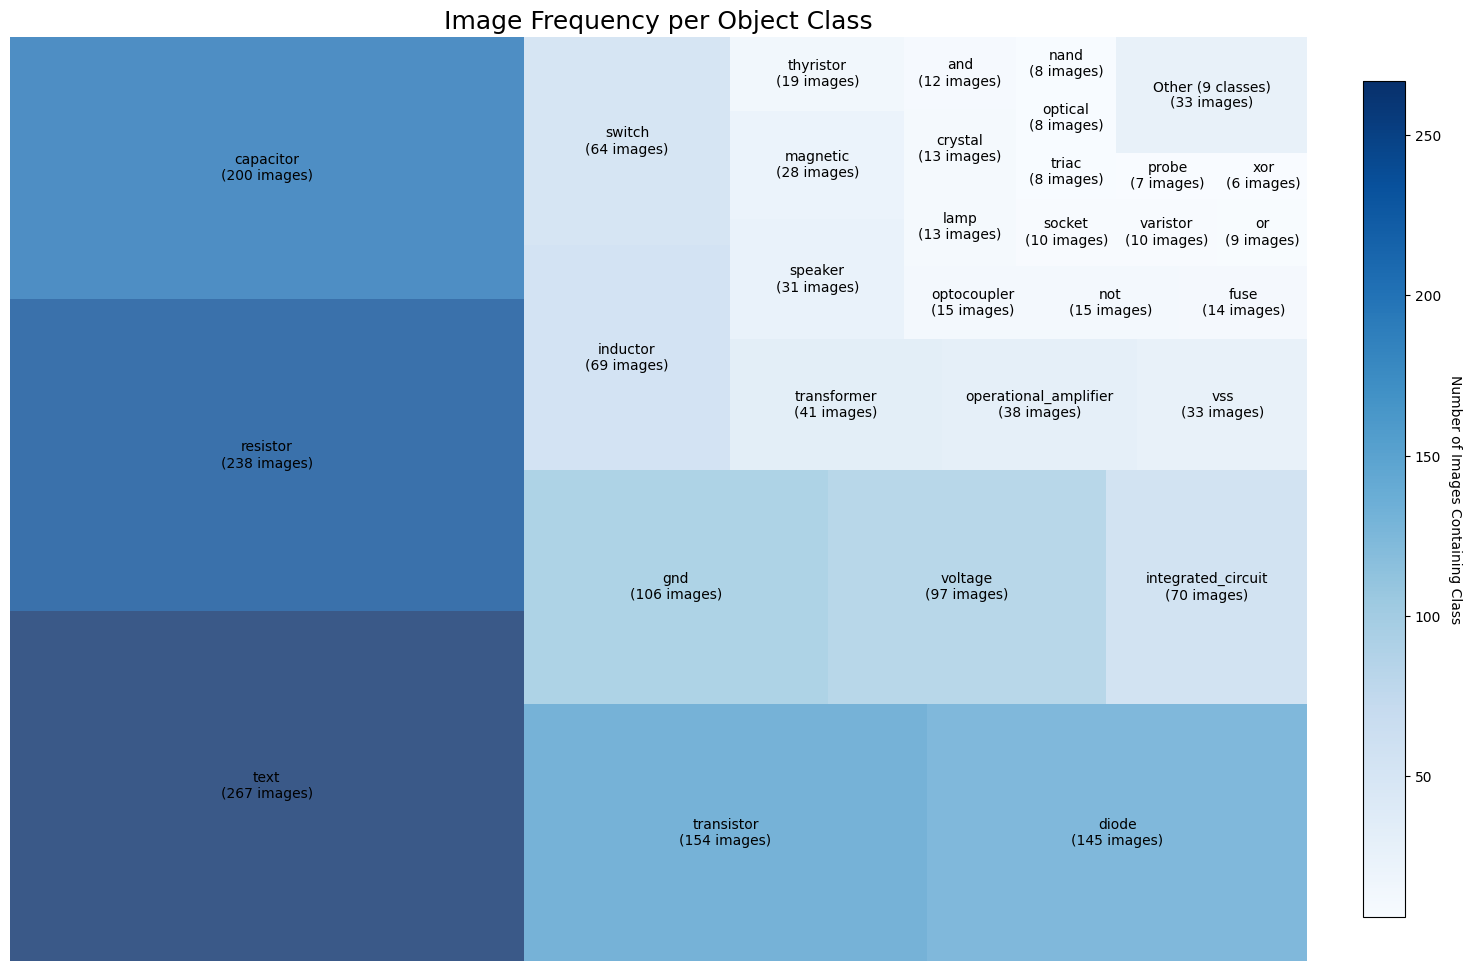

In [3]:
import os
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import squarify # Treemap library
from collections import defaultdict # Useful for grouping
from copy import deepcopy
from tqdm import tqdm # Optional progress bar

# --- Assuming your data loading functions are defined ---
# Functions needed: read_labelme, _sample_info_from_path, read_dataset

# --- Load the Dataset ---
try:
    labelme_ds = read_dataset(segmentation=True)
    print(f"Loaded {len(labelme_ds)} samples.")
    if not labelme_ds:
        raise ValueError("Dataset is empty.")
except NameError:
    print("Error: `read_dataset` function not defined.")
    exit()
except ValueError as e:
    print(e)
    exit()

# --- Function to Group and Count Images per Class ---
def count_images_per_grouped_class(dataset: list) -> dict:
    """
    Groups classes by removing suffixes after '.' and counts the number
    of unique images each grouped class appears in.
    """
    # Use defaultdict(set) to store image indices for each grouped class
    class_to_image_indices = defaultdict(set)

    for idx, sample in enumerate(tqdm(dataset, desc="Counting images per class")):
        polygons = sample.get('polygons', [])
        for polygon in polygons:
            original_class_name = polygon.get('class')
            if original_class_name:
                # Group class name (take part before '.')
                grouped_class_name = original_class_name.split('.')[0]
                # Add the current image index to the set for this grouped class
                class_to_image_indices[grouped_class_name].add(idx)
            # else: # Optionally handle missing class names if needed
            #     class_to_image_indices['__MISSING_CLASS__'].add(idx)

    # Count the number of unique images for each class
    image_counts_per_class = {
        cls: len(indices) for cls, indices in class_to_image_indices.items()
    }

    # Remove missing class tracker if it exists and is empty
    if image_counts_per_class.get('__MISSING_CLASS__', 0) == 0:
        image_counts_per_class.pop('__MISSING_CLASS__', None)

    return image_counts_per_class

# --- Plotting Function (Modified for Image Counts and Styling) ---
def plot_treemap_image_counts(image_counts: dict,
                              top_n: int = None,
                              title="Number of Images Containing Each Object Class (Treemap)",
                              cmap_name: str = 'Blues', # Use Blues colormap
                              text_color: str = 'black'): # Use dark text
    """Generates a treemap visualization of image counts per class."""
    if not image_counts:
        print("No class counts to plot.")
        return

    # Sort items by image count (descending)
    sorted_items = sorted(image_counts.items(), key=lambda item: item[1], reverse=True)

    # Prepare data for squarify
    values = [item[1] for item in sorted_items]
    class_names = [item[0] for item in sorted_items]

    # --- Handle Top N and "Other" category ---
    other_value = 0
    num_original_classes = len(values)
    if top_n is not None and top_n < num_original_classes:
        print(f"Plotting top {top_n} most frequent classes.")
        other_value = sum(values[top_n:])
        values = values[:top_n]
        class_names = class_names[:top_n]
        if other_value > 0:
            values.append(other_value)
            class_names.append(f"Other ({num_original_classes - top_n} classes)")

    # Create labels with class name and image count
    labels = [f"{name}\n({val} images)" for name, val in zip(class_names, values)]

    # --- Color Mapping based on Value ---
    # Normalize values (image counts) to 0-1 range for colormap
    # Handle case where min and max are the same (only one class or all have same count)
    min_val = min(values) if values else 0
    max_val = max(values) if values else 1
    if min_val == max_val:
         # Assign a mid-range color if all values are the same
         norm = mcolors.Normalize(vmin=min_val - 1, vmax=max_val + 1)
    else:
         norm = mcolors.Normalize(vmin=min_val, vmax=max_val)

    cmap = plt.get_cmap(cmap_name)
    colors = [cmap(norm(value)) for value in values]

    # --- Create Treemap ---
    plt.figure(figsize=(18, 12)) # Adjust figure size if needed
    squarify.plot(sizes=values,
                  label=labels,
                  color=colors,
                  alpha=0.8,
                  text_kwargs={'fontsize': 10, 'color': text_color, 'wrap': True}) # Set text color

    plt.title(title, fontsize=18)
    plt.axis('off')

    # --- Add Color Bar ---
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar = plt.colorbar(sm, orientation='vertical', fraction=0.03, pad=0.04)
    cbar.set_label('Number of Images Containing Class', rotation=270, labelpad=15)

    plt.show()

# --- Main Execution ---
image_counts_per_grouped_class = count_images_per_grouped_class(labelme_ds)
num_images = len(labelme_ds) # Total number of images in the dataset

print("\n--- Number of Images Containing Each Grouped Class ---")
# Sort for printing clarity
sorted_counts = sorted(image_counts_per_grouped_class.items(), key=lambda item: item[1], reverse=True)
for cls, count in sorted_counts:
    print(f"{cls}: {count} images ({count/num_images*100:.2f}%)")

print("\nGenerating treemap plot...")
# Plot based on image counts
plot_treemap_image_counts({cls:count for cls, count in image_counts_per_grouped_class.items() if cls not in ("junction", "terminal", "crossover")},
                           top_n=30, # Adjust top_n as needed
                           cmap_name='Blues', # Use a reversed blue map so darker is more frequent
                           text_color='black', # Use black text
                           title="Image Frequency per Object Class")

In [4]:
import os

images_dir = "/kaggle/working/dataset/images"
masks_dir ="/kaggle/working/dataset/masks"
os.makedirs(images_dir, exist_ok = True)
os.makedirs(masks_dir, exist_ok = True)

for i, d in enumerate(labelme_ds):
    image = read_image(d)
    mask = get_selectively_cleaned_mask(d, classes_to_ignore={'text', 'explanatory'})
    #mask = get_mask(d)
    try:
        cv2.imwrite(os.path.join(images_dir, f"{i}.jpg"), image)
        cv2.imwrite(os.path.join(masks_dir, f"{i}.jpg"), mask)
    except:
        print("problem with ", i)

[ WARN:0@57.539] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/cghd1152/drafter_17/images/C196_D2_P4.jpg'): can't open/read file: check file path/integrity


problem with  186


[ WARN:0@58.249] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/cghd1152/drafter_17/images/C198_D2_P1.jpg'): can't open/read file: check file path/integrity


problem with  188


[ WARN:0@59.413] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/cghd1152/drafter_17/images/C202_D1_P2.jpg'): can't open/read file: check file path/integrity


problem with  192


[ WARN:0@59.696] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/cghd1152/drafter_17/images/C203_D1_P3.jpg'): can't open/read file: check file path/integrity


problem with  193


[ WARN:0@82.172] global loadsave.cpp:268 findDecoder imread_('/kaggle/input/cghd1152/drafter_23/images/C265_D1_P2.jpeg'): can't open/read file: check file path/integrity


problem with  246


## Mask Details

In [5]:
import os
import cv2
import numpy as np
from tqdm import tqdm # For progress bar

def calculate_dataset_stats(masks_dir: str, foreground_pixel_value: int = 0):
    """
    Calculates statistics for a segmentation dataset.

    Args:
        masks_dir (str): Path to the directory containing the mask images.
        foreground_pixel_value (int): The pixel value representing the foreground
                                     (e.g., 0 for black objects, 255 for white).

    Returns:
        dict: A dictionary containing the calculated statistics or None if errors occur.
              Keys: 'total_masks_processed', 'avg_contours_per_image',
                    'avg_foreground_ratio_percent'
    """
    if not os.path.isdir(masks_dir):
        print(f"Error: Masks directory not found at {masks_dir}")
        return None

    mask_files = [f for f in os.listdir(masks_dir) if os.path.isfile(os.path.join(masks_dir, f))]
    # Optional: Filter for specific image types if needed, e.g., '.png', '.jpg'
    # mask_files = [f for f in mask_files if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif'))]

    if not mask_files:
        print(f"Error: No mask files found in {masks_dir}")
        return None

    total_contours = 0
    total_foreground_ratio = 0.0
    num_processed_masks = 0
    skipped_files = 0

    print(f"Processing {len(mask_files)} masks...")
    for filename in tqdm(mask_files):
        mask_path = os.path.join(masks_dir, filename)
        try:
            # Read mask in grayscale
            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

            if mask is None:
                print(f"Warning: Could not read mask file: {filename}. Skipping.")
                skipped_files += 1
                continue

            # --- Calculate Foreground Ratio ---
            total_pixels = mask.size
            if total_pixels == 0:
                 print(f"Warning: Mask file {filename} is empty. Skipping.")
                 skipped_files += 1
                 continue

            foreground_pixels = np.sum(mask == foreground_pixel_value)
            foreground_ratio = (foreground_pixels / total_pixels)
            total_foreground_ratio += foreground_ratio

            # --- Find Contours ---
            # Prepare mask for findContours: needs binary image with white objects on black background
            # If foreground is 0 (black), invert. If foreground is 255 (white), use as is.
            if foreground_pixel_value == 0:
                mask_binary = (mask < 128).astype(np.uint8) * 255
            elif foreground_pixel_value == 255:
                 mask_binary = (mask > 128).astype(np.uint8) * 255
            else:
                 # Thresholding for other potential foreground values
                 _, mask_binary = cv2.threshold(mask, foreground_pixel_value - 1, 255, cv2.THRESH_BINARY)


            # Find contours
            contours, _ = cv2.findContours(mask_binary, cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
            total_contours += len(contours)

            num_processed_masks += 1

        except Exception as e:
            print(f"Error processing file {filename}: {e}")
            skipped_files += 1

    if num_processed_masks == 0:
        print("Error: No masks were successfully processed.")
        return None

    # --- Calculate Averages ---
    avg_contours = total_contours / num_processed_masks
    avg_foreground_percent = (total_foreground_ratio / num_processed_masks) * 100

    print("\n--- Calculation Complete ---")
    print(f"Total masks processed: {num_processed_masks}")
    if skipped_files > 0:
        print(f"Total masks skipped due to errors: {skipped_files}")
    print(f"Average Contours per Image: {avg_contours:.2f}")
    print(f"Average Foreground Ratio (%): {avg_foreground_percent:.2f}%")

    return {
        'total_masks_processed': num_processed_masks,
        'avg_contours_per_image': avg_contours,
        'avg_foreground_ratio_percent': avg_foreground_percent
    }

In [6]:
foreground_value = 0

# --- Run Calculation ---
dataset_stats = calculate_dataset_stats(masks_dir, foreground_pixel_value=foreground_value)

Processing 267 masks...


100%|██████████| 267/267 [00:04<00:00, 58.09it/s]


--- Calculation Complete ---
Total masks processed: 267
Average Contours per Image: 70.60
Average Foreground Ratio (%): 2.04%


# Visualizing Examples

In [7]:
import os
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import warnings

def visualize_image_by_index(images_dir: str, index: int, figsize: tuple = (8, 8)):
    """
    Loads and visualizes an image from a directory based on its sorted index.

    Args:
        images_dir (str): Path to the directory containing the images.
        index (int): The 0-based index of the image file to visualize
                     (based on alphanumeric sorting of filenames).
        figsize (tuple): The size of the figure for displaying the image.
    """
    image_path_obj = Path(images_dir)

    if not image_path_obj.is_dir():
        print(f"Error: Directory not found at '{images_dir}'")
        return

    try:
        # Get all files, filter out directories and hidden files, then sort
        image_files = sorted([
            p for p in image_path_obj.iterdir()
            if p.is_file() and not p.name.startswith('.')
        ])

        if not image_files:
            print(f"Error: No image files found in '{images_dir}'")
            return

        # Validate index
        if not (0 <= index < len(image_files)):
            print(f"Error: Index {index} is out of bounds. "
                  f"Directory contains {len(image_files)} images (indices 0 to {len(image_files)-1}).")
            return

        # Get the selected image path
        selected_image_path = image_files[index]
        selected_filename = selected_image_path.name

        # Load the image using OpenCV
        image = cv2.imread(str(selected_image_path))

        if image is None:
            print(f"Error: Failed to load image file: '{selected_image_path}'")
            return

        # Convert from BGR (OpenCV default) to RGB (Matplotlib default)
        image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Display the image
        plt.figure(figsize=figsize)
        plt.imshow(image_rgb)
        plt.title(f"Image at Index {index}: {selected_filename}")
        plt.axis('off') # Hide axes
        plt.show()

    except Exception as e:
        print(f"An error occurred: {e}")

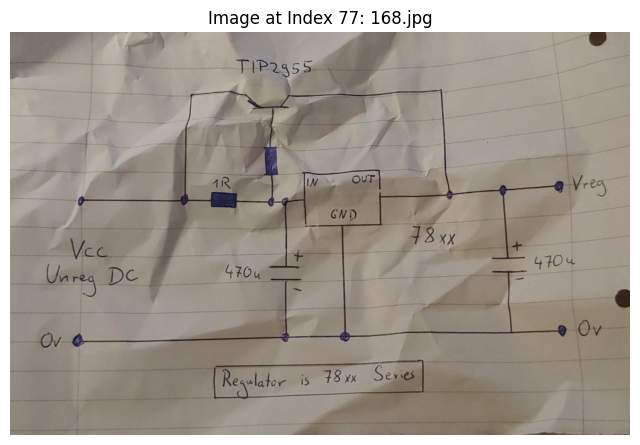

In [8]:
# --- Example Usage ---
# Assuming your images are in '/kaggle/working/dataset/images'

images_directory = "/kaggle/working/dataset/images"
image_index_to_show = 77 # Change this index to view a different image

# Check if the directory exists before calling
if os.path.isdir(images_directory):
    visualize_image_by_index(images_directory, image_index_to_show)
else:
    print(f"Directory '{images_directory}' does not exist. Please check the path.")

# Example to show the first image (index 0)
# visualize_image_by_index(images_directory, 0)

# Example to show the 10th image (index 9)
# visualize_image_by_index(images_directory, 9)

In [9]:
idx = [i for i in range(267)]

# Selecting Points

In [10]:
import os
import cv2
import numpy as np
import random
from pathlib import Path
from typing import List, Tuple, Dict, Optional
import shutil

def get_random_points_for_image(
    images_dir: str,
    masks_dir: str,
    n_images: int,
    n_positive_points: int,
    n_negative_points: int,
    positive_label_value: int = 0, # Value indicating the object in the mask
    verbose: bool = True
) -> List[Dict[str, Optional[List[Tuple[int, int]]]]]:
    """
    Selects random images and samples random positive and negative points from their masks.

    Args:
        images_dir (str): Path to the directory containing images.
        masks_dir (str): Path to the directory containing corresponding masks.
        n_images (int): Number of random images to select.
        n_positive_points (int): Number of points to sample from WITHIN the object mask.
        n_negative_points (int): Number of points to sample from OUTSIDE the object mask.
        positive_label_value (int): The pixel value representing the object/positive class
                                     in the mask files (default is 0).
        verbose (bool): If True, prints warnings for missing files or insufficient points.

    Returns:
        List[Dict[str, Optional[List[Tuple[int, int]]]]]: A list of dictionaries.
            Each dictionary contains:
            - 'image_path': Path to the selected image.
            - 'mask_path': Path to the corresponding mask.
            - 'positive_points': List of (x, y) tuples for positive points, or None if error.
            - 'negative_points': List of (x, y) tuples for negative points, or None if error.
            Returns an empty list if no valid images/masks are found.
    """
    results = []
    image_path_obj = Path(images_dir)
    mask_path_obj = Path(masks_dir)

    if not image_path_obj.is_dir() or not mask_path_obj.is_dir():
        print(f"Error: Images directory '{images_dir}' or masks directory '{masks_dir}' not found.")
        return results

    # Get image stems (filenames without extension) to allow matching different extensions
    try:
        image_stems = [p.stem for p in image_path_obj.iterdir() if p.is_file() and not p.name.startswith('.')]
    except Exception as e:
        print(f"Error listing image files in {images_dir}: {e}")
        return results
        
    if not image_stems:
        print(f"Error: No image files found in {images_dir}")
        return results

    # Ensure n_images is not more than available images
    n_images = min(n_images, len(image_stems))
    if n_images == 0:
        print("Warning: n_images is 0 or no images available.")
        return results

    # Select random image stems
    selected_stems = random.sample(image_stems, n_images)

    for stem in selected_stems:
        image_path: Optional[Path] = None
        mask_path: Optional[Path] = None
        positive_points: Optional[List[Tuple[int, int]]] = None
        negative_points: Optional[List[Tuple[int, int]]] = None

        # Find the actual image and mask files (handle different extensions)
        possible_image_paths = list(image_path_obj.glob(f"{stem}.*"))
        possible_mask_paths = list(mask_path_obj.glob(f"{stem}.*"))

        if not possible_image_paths:
            if verbose: print(f"Warning: Image file for stem '{stem}' not found. Skipping.")
            continue
        if not possible_mask_paths:
            if verbose: print(f"Warning: Mask file for stem '{stem}' not found. Skipping.")
            continue

        image_path = possible_image_paths[0] # Take the first match
        mask_path = possible_mask_paths[0]   # Take the first match

        try:
            # Load the mask in grayscale
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise IOError(f"Failed to load mask: {mask_path}")

            # Find coordinates of positive (object) pixels
            # np.where returns (row_indices, col_indices)
            pos_coords_np = np.argwhere(mask == positive_label_value) # Shape (N, 2) -> [[row, col], ...]

            # Find coordinates of negative (background) pixels
            neg_coords_np = np.argwhere(mask != positive_label_value) # Shape (M, 2) -> [[row, col], ...]

            n_available_pos = len(pos_coords_np)
            n_available_neg = len(neg_coords_np)

            # Sample positive points
            if n_available_pos >= n_positive_points:
                pos_indices = np.random.choice(n_available_pos, n_positive_points, replace=False)
                # Convert selected (row, col) to (x, y) format
                positive_points = [(int(c), int(r)) for r, c in pos_coords_np[pos_indices]]
            else:
                if verbose: print(f"Warning: Only found {n_available_pos} positive points for {stem}, requested {n_positive_points}. Returning available points.")
                positive_points = [(int(c), int(r)) for r, c in pos_coords_np] # Return all available

            # Sample negative points
            if n_available_neg >= n_negative_points:
                neg_indices = np.random.choice(n_available_neg, n_negative_points, replace=False)
                # Convert selected (row, col) to (x, y) format
                negative_points = [(int(c), int(r)) for r, c in neg_coords_np[neg_indices]]
            else:
                if verbose: print(f"Warning: Only found {n_available_neg} negative points for {stem}, requested {n_negative_points}. Returning available points.")
                negative_points = [(int(c), int(r)) for r, c in neg_coords_np] # Return all available

        except Exception as e:
            print(f"Error processing {stem}: {e}")
            # Keep points as None to indicate error for this image

        results.append({
            'image_path': str(image_path) if image_path else None,
            'mask_path': str(mask_path) if mask_path else None,
            'positive_points': positive_points,
            'negative_points': negative_points
        })

    return results

def get_points_for_specific_images(
    images_dir: str,
    masks_dir: str,
    image_indices: List[int], # Changed from n_images
    n_positive_points: int,
    n_negative_points: int,
    positive_label_value: int = 0, # Value indicating the object in the mask
    verbose: bool = True
) -> List[Dict[str, Optional[List[Tuple[int, int]]]]]:
    """
    Selects images by specified indices and samples random positive and negative points
    from their masks.

    Args:
        images_dir (str): Path to the directory containing images.
        masks_dir (str): Path to the directory containing corresponding masks.
        image_indices (List[int]): A list of 0-based indices specifying which images
                                   to process (based on sorted filenames).
        n_positive_points (int): Number of points to sample from WITHIN the object mask.
        n_negative_points (int): Number of points to sample from OUTSIDE the object mask.
        positive_label_value (int): The pixel value representing the object/positive class
                                     in the mask files (default is 0).
        verbose (bool): If True, prints warnings for missing files or insufficient points.

    Returns:
        List[Dict[str, Optional[List[Tuple[int, int]]]]]: A list of dictionaries.
            Each dictionary contains:
            - 'image_path': Path to the selected image.
            - 'mask_path': Path to the corresponding mask.
            - 'positive_points': List of (x, y) tuples for positive points, or None if error.
            - 'negative_points': List of (x, y) tuples for negative points, or None if error.
            Returns an empty list if no valid images/masks are found for the given indices.
    """
    results = []
    image_path_obj = Path(images_dir)
    mask_path_obj = Path(masks_dir)

    if not image_path_obj.is_dir() or not mask_path_obj.is_dir():
        print(f"Error: Images directory '{images_dir}' or masks directory '{masks_dir}' not found.")
        return results

    # --- Get and sort all available image files first ---
    try:
        all_image_files = sorted([
            p for p in image_path_obj.iterdir()
            if p.is_file() and not p.name.startswith('.')
        ])
        num_available_images = len(all_image_files)
    except Exception as e:
        print(f"Error listing image files in {images_dir}: {e}")
        return results

    if num_available_images == 0:
        print(f"Error: No image files found in {images_dir}")
        return results

    # --- Select image paths based on provided indices ---
    selected_image_paths_to_process = []
    invalid_indices = []
    if not image_indices:
        print("Warning: Empty list of image_indices provided.")
        return results

    for index in image_indices:
        if 0 <= index < num_available_images:
            selected_image_paths_to_process.append(all_image_files[index])
        else:
            invalid_indices.append(index)

    if invalid_indices and verbose:
        print(f"Warning: The following indices are out of bounds (0 to {num_available_images - 1}) "
              f"and were skipped: {invalid_indices}")

    if not selected_image_paths_to_process:
        print("Error: None of the provided indices were valid.")
        return results

    # --- Process only the selected image paths ---
    for image_path in selected_image_paths_to_process:
        stem = image_path.stem
        mask_path: Optional[Path] = None
        positive_points: Optional[List[Tuple[int, int]]] = None
        negative_points: Optional[List[Tuple[int, int]]] = None

        # Find the corresponding mask file
        possible_mask_paths = list(mask_path_obj.glob(f"{stem}.*"))
        if not possible_mask_paths:
            if verbose: print(f"Warning: Mask file for stem '{stem}' (index corresponding to {image_path.name}) not found. Skipping.")
            # Append entry with missing mask info if desired, or just continue
            results.append({
                'image_path': str(image_path),
                'mask_path': None,
                'positive_points': None,
                'negative_points': None
            })
            continue # Skip to next image index

        mask_path = possible_mask_paths[0] # Take the first match

        try:
            # Load the mask in grayscale
            mask = cv2.imread(str(mask_path), cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise IOError(f"Failed to load mask: {mask_path}")

            # Find coordinates of positive (object) pixels
            pos_coords_np = np.argwhere(mask == positive_label_value)

            # Find coordinates of negative (background) pixels
            neg_coords_np = np.argwhere(mask != positive_label_value)

            n_available_pos = len(pos_coords_np)
            n_available_neg = len(neg_coords_np)

            # Sample positive points
            if n_available_pos > 0 : # Check if there are any positive points
                num_pos_to_sample = min(n_positive_points, n_available_pos) # Don't request more than available
                pos_indices = np.random.choice(n_available_pos, num_pos_to_sample, replace=False)
                positive_points = [(int(c), int(r)) for r, c in pos_coords_np[pos_indices]]
                if num_pos_to_sample < n_positive_points and verbose:
                     print(f"Warning: Only found {n_available_pos} positive points for {stem}, requested {n_positive_points}. Returning available points.")
            else:
                 if verbose: print(f"Warning: No positive points found for {stem}.")
                 positive_points = [] # Return empty list

            # Sample negative points
            if n_available_neg > 0: # Check if there are any negative points
                num_neg_to_sample = min(n_negative_points, n_available_neg) # Don't request more than available
                neg_indices = np.random.choice(n_available_neg, num_neg_to_sample, replace=False)
                negative_points = [(int(c), int(r)) for r, c in neg_coords_np[neg_indices]]
                if num_neg_to_sample < n_negative_points and verbose:
                     print(f"Warning: Only found {n_available_neg} negative points for {stem}, requested {n_negative_points}. Returning available points.")
            else:
                 if verbose: print(f"Warning: No negative points found for {stem}.")
                 negative_points = [] # Return empty list

        except Exception as e:
            print(f"Error processing {stem} (index corresponding to {image_path.name}): {e}")
            # Keep points as None to indicate error for this image
            positive_points = None
            negative_points = None

        results.append({
            'image_path': str(image_path),
            'mask_path': str(mask_path) if mask_path else None,
            'positive_points': positive_points,
            'negative_points': negative_points
        })

    return results

In [11]:
def save_samples_with_points_and_masks(
    sampled_data: List[Dict[str, Optional[List[Tuple[int, int]]]]],
    output_dir: str,
    point_radius: int = 7e-6,
    save_prefix: str = "sample",
    verbose: bool = True
    ):
    """
    Saves the selected images with points drawn and their original masks to a directory.

    Args:
        sampled_data (List[Dict]): The list of dictionaries returned by
                                   get_random_points_for_image.
        output_dir (str): Path to the directory where files will be saved.
        point_radius (int): Radius of the circles drawn for points.
        save_prefix (str): Prefix for the saved filenames.
        verbose (bool): If True, prints progress and warnings.
    """
    output_path_obj = Path(output_dir)
    output_path_obj.mkdir(parents=True, exist_ok=True) # Create output dir if needed

    saved_count = 0
    error_count = 0

    for i, data in enumerate(sampled_data):
        image_path_str = data.get('image_path')
        mask_path_str = data.get('mask_path')

        if not image_path_str or not mask_path_str:
            if verbose: print(f"Skipping sample {i+1}: Missing image or mask path.")
            error_count += 1
            continue

        image_path = Path(image_path_str)
        mask_path = Path(mask_path_str)
        base_filename = image_path.stem # Use stem for consistent naming

        # Define output filenames
        output_image_filename = f"{save_prefix}_{base_filename}_with_points{image_path.suffix}"
        output_mask_filename = f"{save_prefix}_{base_filename}_mask{mask_path.suffix}"
        output_image_path = output_path_obj / output_image_filename
        output_mask_path = output_path_obj / output_mask_filename

        try:
            # --- Process and Save Image with Points ---
            img = cv2.imread(str(image_path))
            h, w, _ = img.shape
            r = int(point_radius*h*w)
            if img is None:
                raise IOError(f"cv2.imread failed for image: {image_path}")

            img_vis = img.copy() # Work on a copy

            # Draw positive points (Green circles)
            if data.get('positive_points'):
                for (x, y) in data['positive_points']:
                    cv2.circle(img_vis, (x, y), radius=r, color=(0, 255, 0), thickness=-1) # Green

            # Draw negative points (Red circles)
            if data.get('negative_points'):
                for (x, y) in data['negative_points']:
                    cv2.circle(img_vis, (x, y), radius=r, color=(0, 0, 255), thickness=-1) # Red

            # Save the image with points drawn
            cv2.imwrite(str(output_image_path), img_vis)
            if verbose: print(f"Saved image with points: {output_image_path}")

            # --- Copy Original Mask ---
            if mask_path.exists():
                shutil.copyfile(str(mask_path), str(output_mask_path))
                if verbose: print(f"Saved original mask: {output_mask_path}")
            else:
                if verbose: print(f"Warning: Original mask not found at {mask_path}, skipping mask save.")
                # Decide if you want to count this as an error or just proceed
                # error_count += 1 # Uncomment if missing mask is an error

            saved_count += 1

        except Exception as e:
            print(f"Error processing sample {i+1} ({base_filename}): {e}")
            error_count += 1
            # Clean up potentially partially saved files for this sample
            if output_image_path.exists():
                output_image_path.unlink()
            if output_mask_path.exists():
                output_mask_path.unlink()

    print("-" * 20)
    print(f"Finished saving samples.")
    print(f"Successfully saved {saved_count} image/mask pairs.")
    if error_count > 0:
        print(f"Encountered errors with {error_count} samples.")
    print(f"Output directory: {output_dir}")

In [12]:
# --- Example Usage ---
#num_images_to_sample = 3
num_pos_points = 5
num_neg_points = 5
output_save_dir = "/kaggle/working/samples"

# Make sure the directories exist for the example
# os.makedirs(images_dir_example, exist_ok=True)
# os.makedirs(masks_dir_example, exist_ok=True)
# # You would typically have actual image/mask files here
# # For demonstration, let's assume files like '0.jpg', '1.jpg', etc. exist
# # and corresponding masks '0.png', '1.png' exist.

sampled_data = get_points_for_specific_images(
    images_dir=images_dir,
    masks_dir=masks_dir,
    image_indices=idx, # Pass the list of indices
    n_positive_points=num_pos_points,
    n_negative_points=num_neg_points,
    positive_label_value=0 # Assuming 0 is the object
)

# Print the results
for i, data in enumerate(sampled_data):
    print(f"--- Sample {i+1} ---")
    print(f"Image: {data['image_path']}")
    print(f"Mask: {data['mask_path']}")
    print(f"Positive Points ({len(data.get('positive_points', [])) if data.get('positive_points') else 0}): {data['positive_points']}")
    print(f"Negative Points ({len(data.get('negative_points', [])) if data.get('negative_points') else 0}): {data['negative_points']}")
    print("-" * 20)


save_samples_with_points_and_masks(
    sampled_data=sampled_data,
    output_dir=output_save_dir,
    #point_radius=10, # Adjust point size for saved image clarity
    save_prefix="circuit_sample", # Optional prefix for filenames
    verbose=True
)

--- Sample 1 ---
Image: /kaggle/working/dataset/images/0.jpg
Mask: /kaggle/working/dataset/masks/0.jpg
Positive Points (5): [(838, 785), (916, 542), (712, 939), (470, 761), (872, 767)]
Negative Points (5): [(1169, 1150), (816, 1119), (784, 533), (588, 460), (1426, 1021)]
--------------------
--- Sample 2 ---
Image: /kaggle/working/dataset/images/1.jpg
Mask: /kaggle/working/dataset/masks/1.jpg
Positive Points (5): [(538, 449), (647, 237), (586, 339), (248, 255), (314, 262)]
Negative Points (5): [(489, 1018), (851, 965), (852, 917), (407, 502), (717, 398)]
--------------------
--- Sample 3 ---
Image: /kaggle/working/dataset/images/10.jpg
Mask: /kaggle/working/dataset/masks/10.jpg
Positive Points (5): [(1979, 2925), (474, 1488), (1082, 1497), (1971, 2307), (215, 1496)]
Negative Points (5): [(351, 270), (1116, 1590), (966, 2755), (2547, 1301), (1825, 1926)]
--------------------
--- Sample 4 ---
Image: /kaggle/working/dataset/images/100.jpg
Mask: /kaggle/working/dataset/masks/100.jpg
Positi

# Vanilla Sam2

In [13]:
import torch
import torchvision
print("PyTorch version:", torch.__version__)
print("Torchvision version:", torchvision.__version__)
print("CUDA is available:", torch.cuda.is_available())
import sys
!{sys.executable} -m pip install opencv-python matplotlib
!{sys.executable} -m pip install 'git+https://github.com/facebookresearch/sam2.git'

!mkdir -p images
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
!wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg

!mkdir -p ../checkpoints/
!wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

PyTorch version: 2.5.1+cu124
Torchvision version: 0.20.1+cu124
CUDA is available: True
  Cloning https://github.com/facebookresearch/sam2.git to /tmp/pip-req-build-ba8f7zia
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/sam2.git /tmp/pip-req-build-ba8f7zia
  Resolved https://github.com/facebookresearch/sam2.git to commit 2b90b9f5ceec907a1c18123530e92e794ad901a4
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.2/42.2 kB 1.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 6.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━

In [14]:
import warnings

import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import Normalize, Resize, ToTensor


class SAM2Transforms(nn.Module):
    def __init__(
        self, resolution, mask_threshold, max_hole_area=0.0, max_sprinkle_area=0.0
    ):
        """
        Transforms for SAM2.
        """
        super().__init__()
        self.resolution = resolution
        self.mask_threshold = mask_threshold
        self.max_hole_area = max_hole_area
        self.max_sprinkle_area = max_sprinkle_area
        self.mean = [0.485, 0.456, 0.406]
        self.std = [0.229, 0.224, 0.225]
        self.to_tensor = ToTensor()
        self.transforms = nn.Sequential(
                Resize((self.resolution, self.resolution)),
                Normalize(self.mean, self.std),
            )

    def __call__(self, x):
        x = self.to_tensor(x)
        return self.transforms(x)

    def forward_batch(self, img_list):
        img_batch = [self.transforms(self.to_tensor(img)) for img in img_list]
        img_batch = torch.stack(img_batch, dim=0)
        return img_batch

    def transform_coords(
        self, coords: torch.Tensor, normalize=False, orig_hw=None
    ) -> torch.Tensor:
        """
        Expects a torch tensor with length 2 in the last dimension. The coordinates can be in absolute image or normalized coordinates,
        If the coords are in absolute image coordinates, normalize should be set to True and original image size is required.

        Returns
            Un-normalized coordinates in the range of [0, 1] which is expected by the SAM2 model.
        """
        if normalize:
            assert orig_hw is not None
            h, w = orig_hw
            coords = coords.clone()
            coords[..., 0] = coords[..., 0] / w
            coords[..., 1] = coords[..., 1] / h

        coords = coords * self.resolution  # unnormalize coords
        return coords

    def transform_boxes(
        self, boxes: torch.Tensor, normalize=False, orig_hw=None
    ) -> torch.Tensor:
        """
        Expects a tensor of shape Bx4. The coordinates can be in absolute image or normalized coordinates,
        if the coords are in absolute image coordinates, normalize should be set to True and original image size is required.
        """
        boxes = self.transform_coords(boxes.reshape(-1, 2, 2), normalize, orig_hw)
        return boxes

    def postprocess_masks(self, masks: torch.Tensor, orig_hw) -> torch.Tensor:
        """
        Perform PostProcessing on output masks.
        """
        from sam2.utils.misc import get_connected_components

        masks = masks.float()
        input_masks = masks
        mask_flat = masks.flatten(0, 1).unsqueeze(1)  # flatten as 1-channel image
        try:
            if self.max_hole_area > 0:
                # Holes are those connected components in background with area <= self.fill_hole_area
                # (background regions are those with mask scores <= self.mask_threshold)
                labels, areas = get_connected_components(
                    mask_flat <= self.mask_threshold
                )
                is_hole = (labels > 0) & (areas <= self.max_hole_area)
                is_hole = is_hole.reshape_as(masks)
                # We fill holes with a small positive mask score (10.0) to change them to foreground.
                masks = torch.where(is_hole, self.mask_threshold + 10.0, masks)

            if self.max_sprinkle_area > 0:
                labels, areas = get_connected_components(
                    mask_flat > self.mask_threshold
                )
                is_hole = (labels > 0) & (areas <= self.max_sprinkle_area)
                is_hole = is_hole.reshape_as(masks)
                # We fill holes with negative mask score (-10.0) to change them to background.
                masks = torch.where(is_hole, self.mask_threshold - 10.0, masks)
        except Exception as e:
            # Skip the post-processing step if the CUDA kernel fails
            warnings.warn(
                f"{e}\n\nSkipping the post-processing step due to the error above. You can "
                "still use SAM 2 and it's OK to ignore the error above, although some post-processing "
                "functionality may be limited (which doesn't affect the results in most cases; see "
                "https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).",
                category=UserWarning,
                stacklevel=2,
            )
            masks = input_masks

        masks = F.interpolate(masks, orig_hw, mode="bilinear", align_corners=False)
        return masks

In [15]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image

In [16]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [17]:
np.random.seed(3)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE) 
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2) 
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))    

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

In [18]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
sam2_model.use_high_res_features_in_sam = True

predictor = SAM2ImagePredictor(sam2_model)

In [19]:
_transforms = SAM2Transforms(
            resolution=sam2_model.image_size,
            mask_threshold=0,
            max_hole_area=0,
            max_sprinkle_area=0,
)

In [20]:
def get_predictions(indices, sampled_data):
    image_path_obj = Path(images_dir)
    preds = []
    
    if not image_path_obj.is_dir():
        print(f"Error: Directory not found at '{images_dir}'")
        return
        
    try:
        # Get all files, filter out directories and hidden files, then sort
        image_files = sorted([
            p for p in image_path_obj.iterdir()
            if p.is_file() and not p.name.startswith('.')
        ])

        if not image_files:
            print(f"Error: No image files found in '{images_dir}'")
            return

        for i, index in enumerate(indices):
            if not (0 <= index < len(image_files)):
                print(f"Error: Index {index} is out of bounds. "
                      f"Directory contains {len(image_files)} images (indices 0 to {len(image_files)-1}).")
                return
    
            # Get the selected image path
            selected_image_path = image_files[index]
            selected_filename = selected_image_path.name
    
            # Load the image using OpenCV
            image = Image.open(str(selected_image_path))
            image = np.array(image.convert("RGB"))
            predictor.set_image(image)
            input_point = np.array(sampled_data[i]["positive_points"]+sampled_data[i]["negative_points"])
            input_label = np.array([1 for _ in sampled_data[i]["positive_points"]]+[0 for _ in sampled_data[i]["negative_points"]])
            
            masks, scores, logits = predictor.predict(
                point_coords=input_point,
                point_labels=input_label,
                multimask_output=False,
            )
            sorted_ind = np.argsort(scores)[::-1]
            masks = masks[sorted_ind]
            scores = scores[sorted_ind]
            logits = logits[sorted_ind]
            preds.append(logits)
    except:
        pass
            
    return preds

In [21]:
predictions = get_predictions(idx, sampled_data)

In [22]:
import torch
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os
from pathlib import Path

def save_resized_binary_masks_and_show(
    predictions: List[torch.Tensor], # List of logit tensors
    output_dir: str,
    original_image_paths: List[str], # List of corresponding original image paths
    threshold: float = 0,
    save_prefix: str = "pred_mask_resized",
    show_sample_index: int = 0,
    verbose: bool = True
    ):
    """
    Converts predicted logit masks to binary, resizes them to original dimensions,
    saves them, and shows one sample.

    Args:
        predictions (List[torch.Tensor]): List of predicted mask logits (N, C, H, W) or (N, H, W).
        output_dir (str): Directory to save the binary masks.
        original_image_paths (List[str]): List of paths to the original input images.
                                          Must be the same length as predictions.
        threshold (float): Threshold for binarization.
        save_prefix (str): Prefix for saved filenames.
        show_sample_index (int): Index within the predictions list to visualize.
        verbose (bool): If True, prints progress and warnings.
    """
    if len(predictions) != len(original_image_paths):
        raise ValueError("Length of predictions list must match length of original_image_paths list.")

    output_path_obj = Path(output_dir)
    output_path_obj.mkdir(parents=True, exist_ok=True)

    saved_mask_path_resized = None
    mask_to_show_resized = None # Store the numpy array for visualization

    for i, logits_tensor in enumerate(predictions):
        original_image_path_str = original_image_paths[i]
        original_image_path = Path(original_image_path_str)
        base_filename = original_image_path.stem
        output_filename = f"{save_prefix}_{base_filename}.png" # Save as PNG
        output_mask_path = output_path_obj / output_filename

        try:
            # --- Get Original Dimensions ---
            original_image = cv2.imread(original_image_path_str)
            if original_image is None:
                raise IOError(f"Failed to load original image to get size: {original_image_path_str}")
            original_height, original_width = original_image.shape[:2]

            # --- Binarization (at model output size) ---
            #probabilities = torch.sigmoid(logits_tensor)
            binary_mask_bool = (logits_tensor > threshold)
            binary_mask_np_small = binary_mask_bool.squeeze().astype(np.uint8)
            # Don't multiply by 255 yet, keep as 0/1 for resizing

            # --- Resizing ---
            # Use INTER_NEAREST for binary masks to avoid introducing intermediate gray values
            resized_binary_mask_np = cv2.resize(
                binary_mask_np_small,
                (original_width, original_height), # OpenCV uses (width, height)
                interpolation=cv2.INTER_LINEAR
            )

            # --- Convert to 0/255 for Saving ---
            resized_binary_mask_np_save = (1-resized_binary_mask_np) * 255

            # --- Saving Resized Mask ---
            cv2.imwrite(str(output_mask_path), resized_binary_mask_np_save)
            # print(f"Saved resized binary mask: {output_mask_path}") # Optional

            # --- Store for Visualization ---
            if i == show_sample_index:
                saved_mask_path_resized = str(output_mask_path)
                # Store the 0/255 mask for imshow
                mask_to_show_resized = resized_binary_mask_np_save

        except Exception as e:
            print(f"Error processing prediction {i} (original: {original_image_path_str}): {e}")
            if output_mask_path.exists(): # Clean up partial save if error occurred
                 output_mask_path.unlink()


    # --- Visualization ---
    if show_sample_index < len(predictions) and saved_mask_path_resized and mask_to_show_resized is not None:
        print(f"\nVisualizing Resized Sample Index: {show_sample_index}")
        print(f"Saved Resized Mask Path: {saved_mask_path_resized}")
        plt.figure(figsize=(8, 8))
        plt.imshow(mask_to_show_resized, cmap='gray') # Use grayscale colormap
        plt.title(f"Predicted Resized Binary Mask (Index {show_sample_index})")
        plt.axis('off')
        plt.show()
    elif show_sample_index >= len(predictions):
         print(f"\nWarning: show_sample_index ({show_sample_index}) is out of bounds "
               f"for the predictions list (length {len(predictions)}). No visualization shown.")
    elif not saved_mask_path_resized:
         print(f"\nWarning: Could not save or find the resized mask for the sample index "
               f"{show_sample_index} to visualize (check for errors above).")

In [23]:
predictions[0].shape

(1, 256, 256)


Visualizing Resized Sample Index: 0
Saved Resized Mask Path: /kaggle/working/samples/pred_binary_0.png


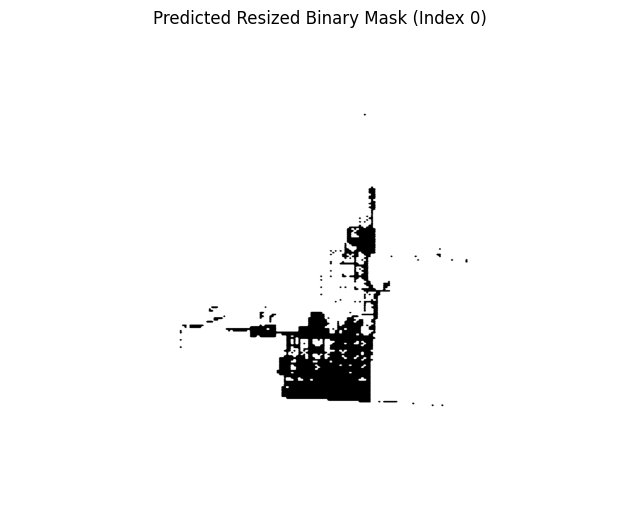

In [24]:
# --- Example Usage ---
# Assume 'predictions' is a list of your model's output logit tensors
# Assume 'sampled_data_specific' contains the corresponding original image info

# Dummy example data (replace with your actual data)
original_paths = [d['image_path'] for d in sampled_data]

save_resized_binary_masks_and_show(
    predictions=predictions, # Your actual predictions list
    output_dir=output_save_dir,
    original_image_paths=original_paths, # Paths corresponding to predictions
    threshold=0, # Adjust as needed
    save_prefix="pred_binary",
    show_sample_index=0 # Show the first predicted mask
)

In [25]:
!zip -r /kaggle/working/zero_shot_inference.zip ./samples

  adding: samples/ (stored 0%)
  adding: samples/circuit_sample_131_with_points.jpg (deflated 0%)
  adding: samples/circuit_sample_17_with_points.jpg (deflated 0%)
  adding: samples/circuit_sample_75_with_points.jpg (deflated 0%)
  adding: samples/circuit_sample_73_mask.jpg (deflated 15%)
  adding: samples/circuit_sample_86_mask.jpg (deflated 18%)
  adding: samples/pred_binary_60.png (deflated 38%)
  adding: samples/circuit_sample_109_mask.jpg (deflated 46%)
  adding: samples/pred_binary_212.png (deflated 50%)
  adding: samples/pred_binary_1.png (deflated 48%)
  adding: samples/circuit_sample_179_mask.jpg (deflated 21%)
  adding: samples/pred_binary_168.png (deflated 49%)
  adding: samples/circuit_sample_11_mask.jpg (deflated 40%)
  adding: samples/pred_binary_127.png (deflated 38%)
  adding: samples/circuit_sample_253_mask.jpg (deflated 34%)
  adding: samples/pred_binary_126.png (deflated 44%)
  adding: samples/pred_binary_10.png (deflated 44%)
  adding: samples/circuit_sample_82_mask